In [1]:

import pandas as pd
import matplotlib.pyplot  as plt
import matplotlib.ticker as ticker
import numpy as np
import seaborn as sns
import datetime as dt
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse    
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
#Options
params = {'legend.fontsize': 9,
          'figure.figsize': (15, 5),
         'axes.labelsize': 10,
         'axes.titlesize':11,
         'xtick.labelsize':10,
         'ytick.labelsize':10,
         'axes.grid': True,
         'axes.grid.which': 'both',	
         'grid.linestyle': '--',
         'grid.color': 'silver',
         'grid.alpha': 0.6,
         'lines.linewidth': 1,         
         'lines.markersize': 2
         
         }

plt.rcParams.update(params)
plt.rcParams['figure.dpi'] = 150
blue = '#005AB5'
red = '#DC3220' 

# Analysis of monthly data

In [3]:
Month_data = pd.read_csv('../Data/02_TEU_month.csv',index_col=0)

Month_data.index = pd.to_datetime(Month_data.index)
Month_data.index.freq = 'MS'
Month_data.head()

,TEU
Date,
2010-01-01,493.136
2010-02-01,447.869
2010-03-01,532.599
2010-04-01,485.357
2010-05-01,596.628


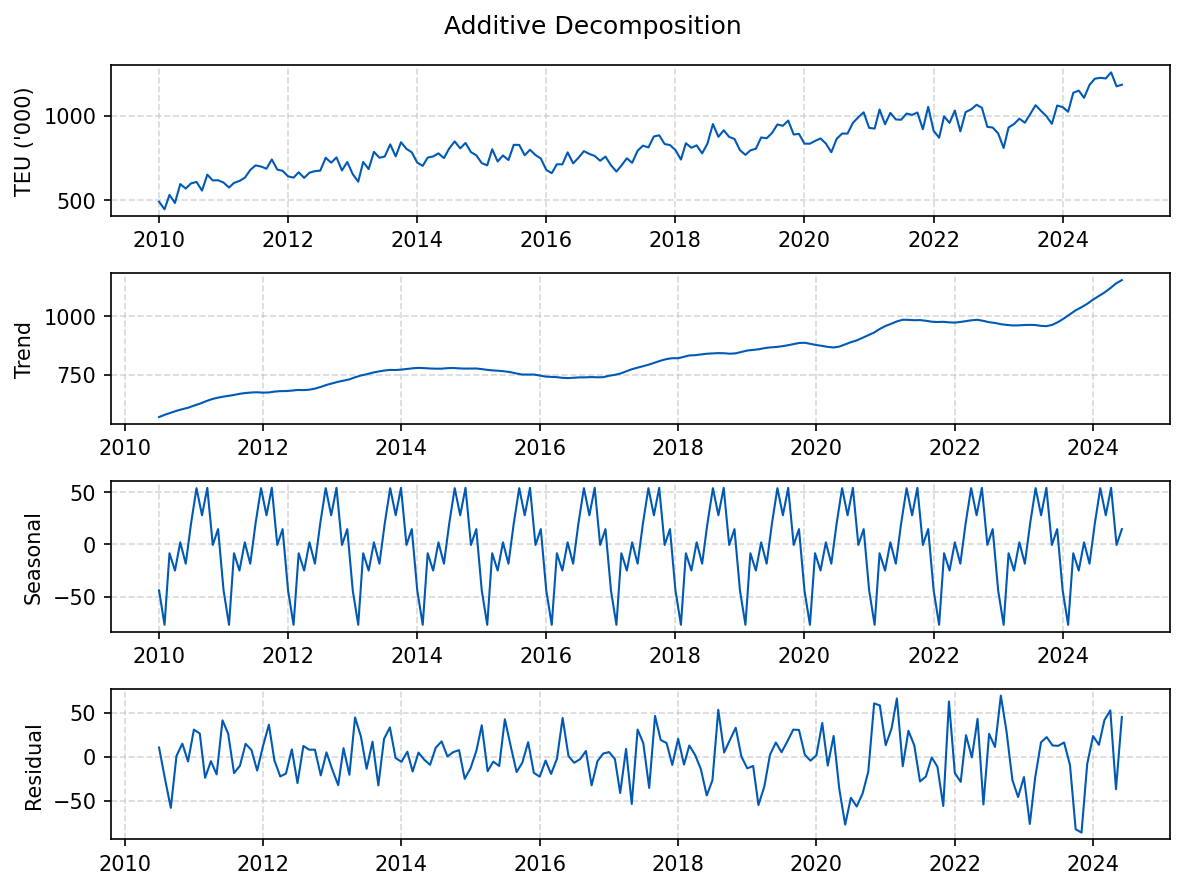

In [4]:
additive_decomposition = seasonal_decompose(Month_data['TEU'], model='add', period=12)

plt.figure(figsize=(8, 6) )

plt.subplot(411)
plt.plot(Month_data['TEU'], color=blue)
plt.ylabel("TEU ('000)")

plt.subplot(412)
plt.plot(additive_decomposition.trend, color= blue)
plt.ylabel("Trend")

plt.subplot(413)
plt.plot(additive_decomposition.seasonal, color= blue)
plt.ylabel("Seasonal")

plt.subplot(414)
plt.plot(additive_decomposition.resid, color= blue)
plt.ylabel("Residual")


plt.suptitle('Additive Decomposition')

plt.tight_layout()

plt.savefig('../Figures/svg/Figure07.svg')
plt.savefig('../Figures/png/Figure07.png', dpi=600)
plt.show()


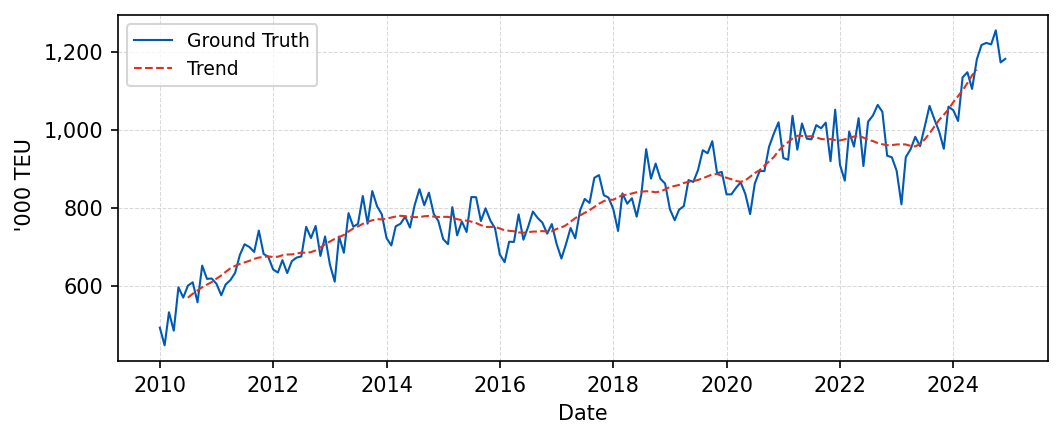

In [5]:
plt.figure(figsize=(8, 3) )

sns.lineplot(x=Month_data.index, y=Month_data['TEU'], label='Ground Truth', color=blue)
sns.lineplot(x=Month_data.index, y=additive_decomposition.trend, label='Trend', color=red, linestyle='dashed')

plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.xlabel('Date')
plt.ylabel(" '000 TEU")
plt.legend(loc='best', fontsize=9)

plt.grid(linestyle='--', linewidth=0.5)

plt.show()

## Check Stationarity

In [6]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series):
    # Adapted from https://machinelearningmastery.com/time-series-data-stationary-python/
    ''' Check if time series is Stationary'''
    
    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [7]:
print(check_stationarity(Month_data['TEU']))

ADF Statistic: 0.480012
p-value: 0.984253
Critical Values:
	1%: -3.470
	5%: -2.879
	10%: -2.576
Non-stationary
None


## ACF and PACF analysis

In [8]:
import statsmodels.formula.api as smf            
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from itertools import product
from tqdm import tqdm_notebook

In [9]:
def tsplot(y, lags=None, figsize=(8, 4)):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
        
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
        
    y.plot(ax=ts_ax)
    p_value = adfuller(y)[1]
    ts_ax.set_title('Series')
    ts_ax.set_facecolor('white') 
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    acf_ax.set_facecolor('white')

    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    pacf_ax.set_facecolor('white')

    plt.suptitle('Dickey-Fuller: p={0:.5f}'.format(p_value))
    plt.tight_layout()

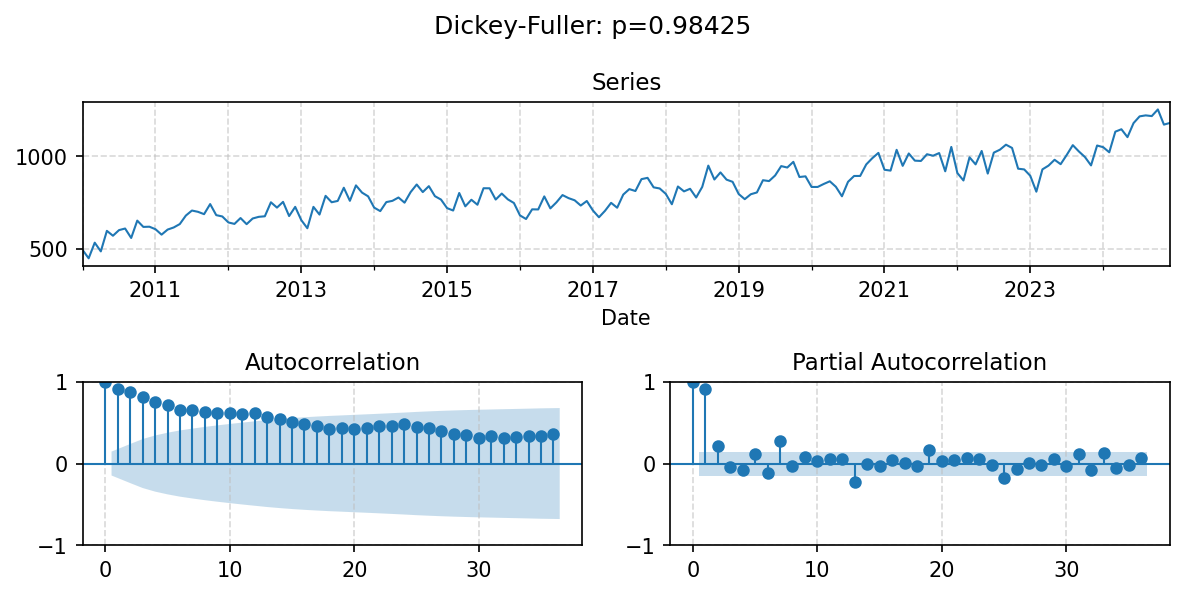

In [10]:
tsplot(Month_data['TEU'], lags=36)
plt.savefig('../Figures/svg/Figure08.svg')
plt.savefig('../Figures/png/Figure08.png', dpi=600)

### Remove seasonal component



Subtract the series from itself on a lag of the seasonal component

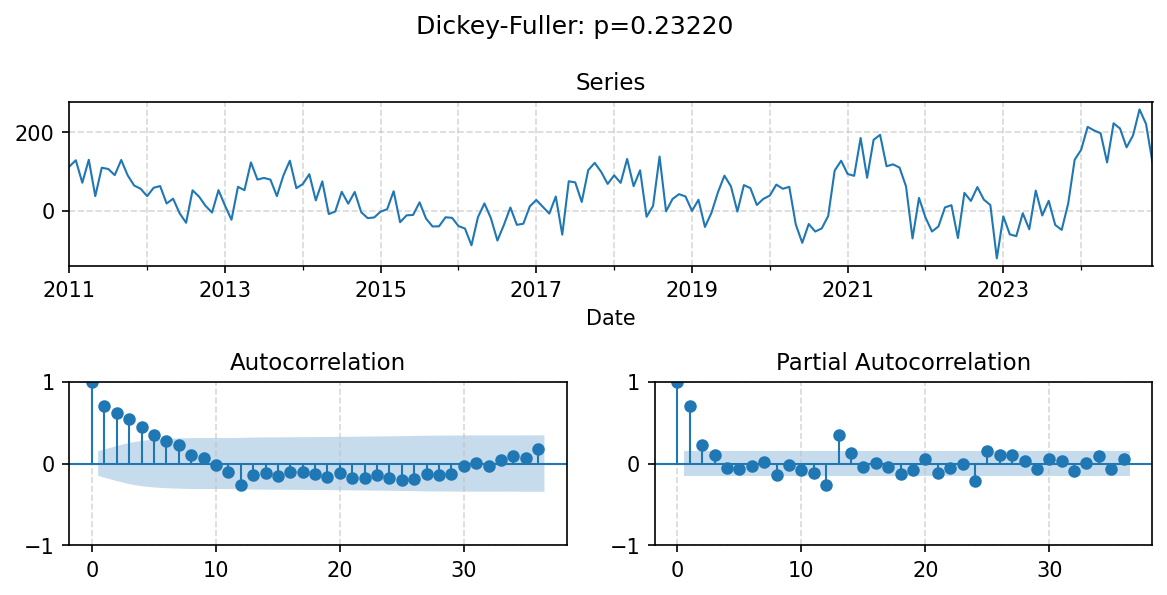

In [11]:
TEU_diff = Month_data['TEU'] - Month_data['TEU'].shift(12)
tsplot(TEU_diff[12:], lags=36)

###  1st difference
 Subtract from lag 1

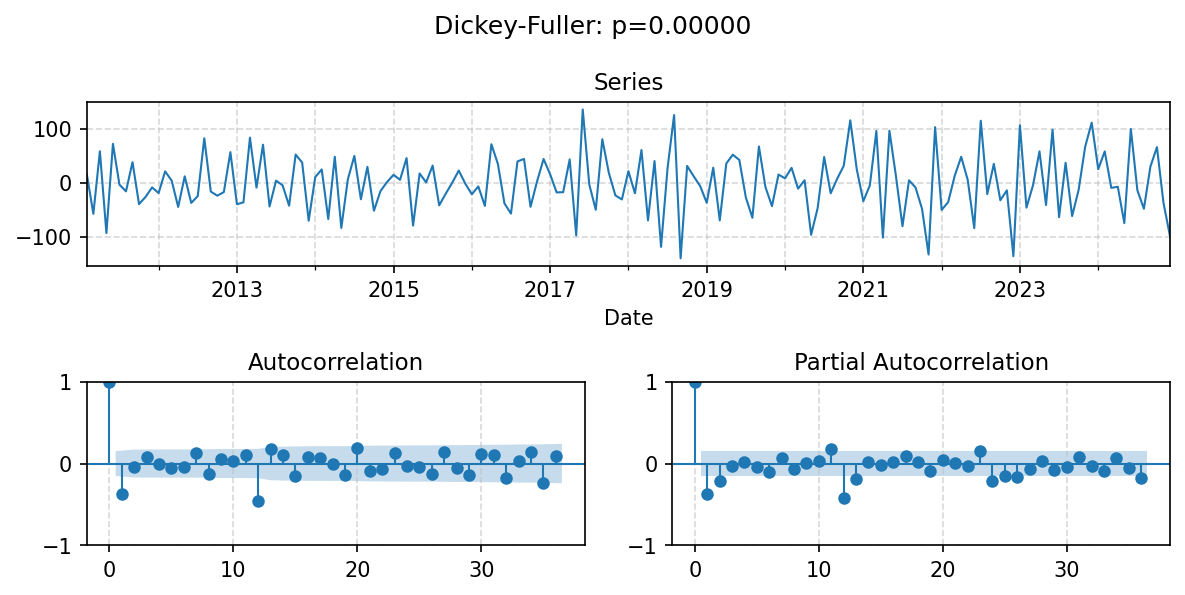

In [12]:
TEU_diff = TEU_diff- TEU_diff.shift(1)
tsplot(TEU_diff[12+1:], lags=36)
plt.savefig('../Figures/svg/Figure09.svg')
plt.savefig('../Figures/png/Figure09.png', dpi=600)

## ARIMA p, d, q Combinations

In [13]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 

    '''Calculate MAPE
    y_true - target values
    y_pred - predicted values'''
    
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## Set model delection

In [14]:
def Split_TimeSeries(data, size):
    Train, Test = data[:-size], data[-size:]
    return Train, Test

In [15]:
test_size = 24
X_train, X_test = Split_TimeSeries(Month_data['TEU'], test_size)

## Build grid search function

In [16]:
from sklearn.model_selection import TimeSeriesSplit

def optimizeSARIMA(series_col, test, parameters_list, d, D, s, n_splits=5):
    """
        Return dataframe with parameters and corresponding evaluation metrics
        for defining ARIMA models with cross-validation

        Calculates average AIC on CV models, and select model
        with the lowest avg_AIC
        
        parameters_list - list with (p, q, P, Q) 
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
        n_splits - number of cross-validation splits
    """
    
    results = []
    best_aic = float("inf")
    best_model = None
    best_param = None
    
  
    tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size)
    
    # use only training data for cross-validation
    train_data = series_col.reset_index(drop=True)
    
    for param in tqdm_notebook(parameters_list):
        cv_errors = []
        cv_AIC = []
        
        # Perform time series cross-validation
        for train_idx, val_idx in tscv.split(train_data):
            # Create training and validation sets for this fold
            fold_train = train_data.iloc[train_idx]
            fold_val = train_data.iloc[val_idx]
            
            # Skip if we don't have enough training data
            if len(fold_train) <= max(param[0] + d + param[1], param[2] + D + param[3] * s):
                continue
            
            # fit the model
            try:
                model = sm.tsa.statespace.SARIMAX(
                    fold_train,
                    order=(param[0], d, param[1]), 
                    seasonal_order=(param[2], D, param[3], s)
                ).fit(disp=-1)
                
                # Forecast validation set
                forecast = model.get_forecast(steps=len(fold_val))
                predicted = forecast.predicted_mean
                
                # Calculate error on validation 
                error_val = mean_absolute_percentage_error(fold_val, predicted)
                cv_errors.append(error_val) #List MAPE results
                AIC_val = model.aic
                cv_AIC.append(AIC_val) # List AIC results

                
            except:
                # If model fails to converge skip 
                continue
        
        # calculate average error
        if cv_errors:
            avg_cv_error = sum(cv_errors) / len(cv_errors)
            aic_avg = sum(cv_AIC) / len(cv_AIC)
            
            # Final evaluation on the test set with the full training data
            try:
                final_model = sm.tsa.statespace.SARIMAX(
                    series_col,
                    order=(param[0], d, param[1]), 
                    seasonal_order=(param[2], D, param[3], s)
                ).fit(disp=-1)
                
                forecast = final_model.get_forecast(steps=len(test))
                predicted = forecast.predicted_mean
                
                error_test = mean_absolute_percentage_error(test, predicted)
                
                # Save parameters and errors of the model
                results.append([param, avg_cv_error, aic_avg, error_test])
                
                # Update best model if avg_AIC is better
                if aic_avg < best_aic:
                    best_model = final_model
                    best_aic = error_test
                    best_param = param
            except:
                continue

    # Create result table with cross-validation and test errors
    if results:
        result_table = pd.DataFrame(results)
        result_table.columns = ['parameters', 'cv_mape', 'AIC', 'test_mape']
        # Sort by cross-validation avg_AIC
        result_table = result_table.sort_values(by=['AIC'], ascending=True).reset_index(drop=True)
        
        return result_table, best_model, best_param
    else:
        return pd.DataFrame(columns=['parameters', 'cv_mape', 'AIC', 'test_mape']), None, None






In [17]:
%%time
# Define search range
ps = range(0, 3)
d=1 
qs = range(0, 3)
Ps = range(0, 3)
D=1 
Qs = range(0, 3)
s = 12 

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
print( len(parameters_list) )

# Run optimization with cross-validation using TimeSeriesSplit
result_table, best_model, best_params = optimizeSARIMA(
    X_train,
    X_test, 
    parameters_list, 
    d=1,  # differencing order
    D=1,  # seasonal differencing order
    s=12, # seasonal period (12 months)
    n_splits=5  # number of cross-validation splits
)

print(f"Best parameters (p,q,P,Q): {best_params}")
print(f"Best test MAPE: {result_table.iloc[0]['test_mape']:.4f}")
print(f"Best CV MAPE: {result_table.iloc[0]['cv_mape']:.4f}")

81


C:\Users\rafae\AppData\Local\Temp\ipykernel_38036\1208648088.py:29: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for param in tqdm_notebook(parameters_list):


  0%|          | 0/81 [00:00<?, ?it/s]

c:\Users\rafae\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\rafae\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
c:\Users\rafae\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\rafae\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warni

Best parameters (p,q,P,Q): (0, 0, 0, 0)
Best test MAPE: 9.2707
Best CV MAPE: 6.4787
CPU times: total: 5min 27s
Wall time: 5min 24s


In [18]:
sort_AIC = result_table
sort_AIC

,parameters,cv_mape,AIC,test_mape
0,"(0, 1, 0, 1)",6.478690,702.745635,9.270738
1,"(0, 1, 2, 1)",5.749857,702.955014,9.103396
2,"(0, 1, 2, 0)",7.793613,702.989735,10.214874
3,"(0, 1, 0, 2)",6.640846,703.948107,9.230336
4,"(0, 1, 1, 1)",6.815929,704.146516,9.254771
...,...,...,...,...
76,"(2, 1, 0, 0)",6.386992,728.733941,15.364792
77,"(2, 0, 0, 0)",6.522776,729.232125,15.892081
78,"(0, 0, 1, 0)",6.109985,734.262173,19.328467
79,"(1, 0, 0, 0)",6.629434,734.494387,18.989800


In [19]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
AIC_scaled = scaler.fit_transform(sort_AIC['AIC'].values.reshape(-1,1))
MAPE_scaled = scaler.fit_transform(sort_AIC['test_mape'].values.reshape(-1,1))

sort_AIC['AIC'] = AIC_scaled
sort_AIC['test_mape'] = MAPE_scaled


## Create error results combination to balance train and test resuts

In [20]:
sort_AIC['combine'] = sort_AIC['AIC'] + sort_AIC['test_mape']
final_result = sort_AIC.sort_values(by=['combine'], ascending=True).reset_index(drop=True)
final_result

,parameters,cv_mape,AIC,test_mape,combine
0,"(0, 1, 2, 1)",5.749857,0.004632,0.043716,0.048348
1,"(0, 1, 0, 1)",6.478690,0.000000,0.054204,0.054204
2,"(2, 2, 2, 1)",6.132547,0.066086,0.000000,0.066086
3,"(0, 1, 0, 2)",6.640846,0.026599,0.051672,0.078271
4,"(0, 1, 1, 1)",6.815929,0.030988,0.053203,0.084191
...,...,...,...,...,...
76,"(2, 1, 0, 0)",6.386992,0.574877,0.436139,1.011016
77,"(2, 0, 0, 0)",6.522776,0.585897,0.469186,1.055083
78,"(1, 0, 0, 0)",6.629434,0.702302,0.663330,1.365632
79,"(0, 0, 1, 0)",6.109985,0.697165,0.684556,1.381721


## Cross Validation illustration

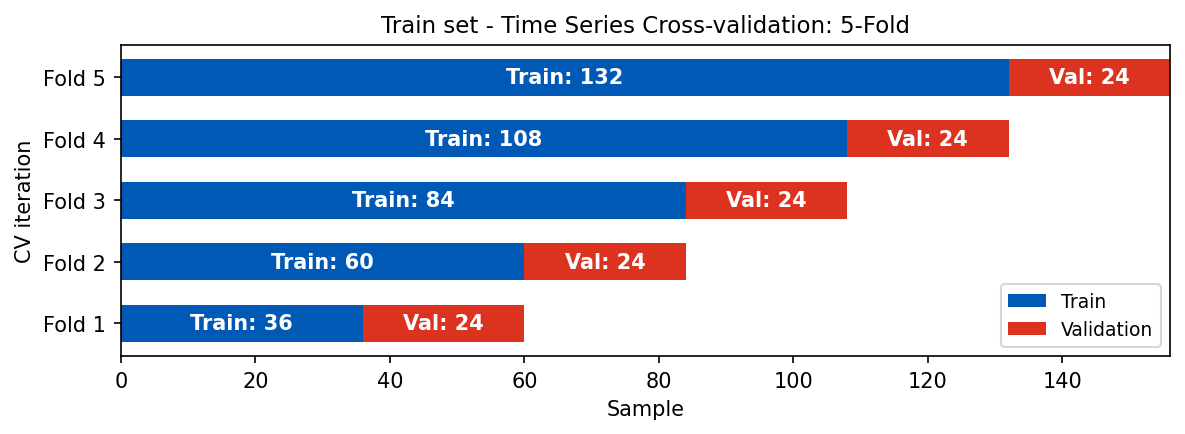

In [89]:
import matplotlib.patches as mpatches
X = np.arange(len(X_train))
tscv = TimeSeriesSplit(n_splits=5, test_size=test_size)

# Set up the figure
plt.figure(figsize=(8, 3))


# Plot the CV splits as horizontal bars
for i, (train_idx, val_idx) in enumerate(tscv.split(X_train)):
    # Plot training data as blue bars
    plt.barh(y=i, width=len(train_idx), left=0, height=0.6,
            color=blue,
            label='Train' if i == 0 else "")
    
    # Plot validation data as red bars
    plt.barh(y=i, width=len(val_idx), left=len(train_idx), height=0.6, 
             color=red,
            label='Validation' if i == 0 else "")
    
    # Add text to show sizes
    plt.text(len(train_idx)/2, i, f"Train: {len(train_idx)}", 
             ha='center', va='center', color='white', fontweight='bold')
    
    if len(val_idx) > 10:  # Only add text if there's enough space
        plt.text(len(train_idx) + len(val_idx)/2, i, f"Val: {len(val_idx)}", 
                ha='center', va='center', color='white', fontweight='bold')


# Add legend, title and labels
plt.legend( loc='best', fontsize=9)
plt.title('Train set - Time Series Cross-validation: 5-Fold')
plt.xlabel('Sample')
plt.ylabel('CV iteration')
plt.yticks([0, 1, 2, 3, 4], ['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5'])
plt.xlim(0, len(X_train))
plt.grid(False)

plt.tight_layout()

plt.savefig('../Figures/svg/Figure06.svg')
plt.savefig('../Figures/png/Figure06.png', dpi=600)
plt.show()

In [53]:
final_result.parameters[0]

(0, 1, 2, 1)

## Best Model

In [54]:
p, q, P, Q = final_result.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(X_train, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s),
                                        ).fit()
print(best_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                TEU   No. Observations:                  156
Model:             SARIMAX(0, 1, 1)x(2, 1, 1, 12)   Log Likelihood                -718.690
Date:                            Fri, 09 May 2025   AIC                           1447.380
Time:                                    18:33:26   BIC                           1462.194
Sample:                                01-01-2010   HQIC                          1453.399
                                     - 12-01-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4997      0.068     -7.325      0.000      -0.633      -0.366
ar.S.L12      -0.2174      0.164   

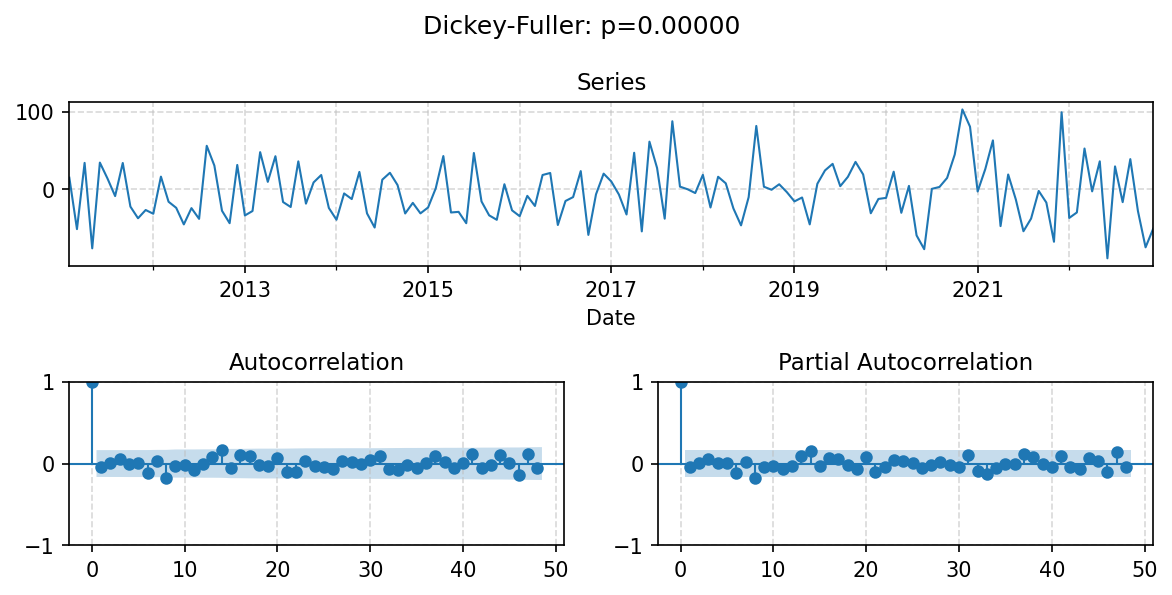

In [55]:
tsplot(best_model.resid[12+1:], lags=48)

# Evaluation and plot on test set

In [56]:
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

Train MAPE: 3.64%
Train RMSE: 58.69
Test MAPE: 9.10%
Test RMSE: 125.07


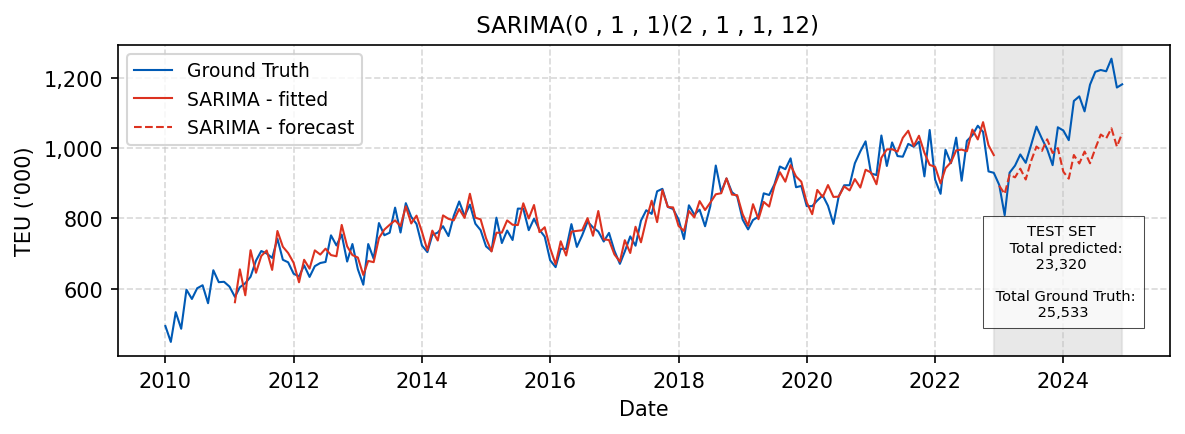

In [59]:
fitted = best_model.fittedvalues
forecast = best_model.predict(start = X_train.shape[0], end = X_train.shape[0]+len(X_test)-1)
X = pd.concat([X_train, X_test])

train_MAPE = mean_absolute_percentage_error(X_train.TEU[s+d:], fitted)
train_RMSE = np.sqrt(mean_squared_error(X_train.TEU, fitted))
test_MAPE = mean_absolute_percentage_error(X_test.TEU, forecast)
test_RMSE = np.sqrt(mean_squared_error(X_test.TEU, forecast))


Predicted_test = sum(forecast)
Real_test = sum(X_test.TEU)

print("Train MAPE: {0:.2f}%".format(train_MAPE))
print("Train RMSE: {0:.2f}".format(train_RMSE))
print("Test MAPE: {0:.2f}%".format(test_MAPE))
print("Test RMSE: {0:.2f}".format(test_RMSE))

############## PLOT #################
plt.figure(figsize=(8, 3))

plt.plot(X.TEU, color=blue, label="Ground Truth")
plt.plot(fitted[s+d:], color= red, label="SARIMA - fitted" )  
plt.plot(forecast, color=red, label="SARIMA - forecast" ,linestyle = '--')

plt.xlabel('Date')
plt.ylabel("TEU ('000)")

plt.axvspan(X_train.index[-1], forecast.index[-1], color='lightgrey', alpha=0.5)

plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))

plt.text(forecast.index[int(round(forecast.shape[0]/2 , 0 ))], X_test.min()*0.8,
         'TEST SET \n Total predicted:\n {:,.0f}  \n\n Total Ground Truth:\n {:,.0f} '.format(Predicted_test, Real_test),
         fontsize=7,
         bbox=dict(facecolor='white',
                   alpha=0.7,
                   edgecolor='black',
                   linewidth=0.5),
                   va='center',
                   ha='center')



plt.legend(loc='best', fontsize=9)
plt.title(f' SARIMA({p} , {d} , {q})({P} , {D} , {Q}, {s})' )

plt.tight_layout()

plt.savefig('../Figures/svg/Figure_ARIMA.svg')
plt.savefig('../Figures/png/Figure_ARIMA.png', dpi=600)
plt.show();

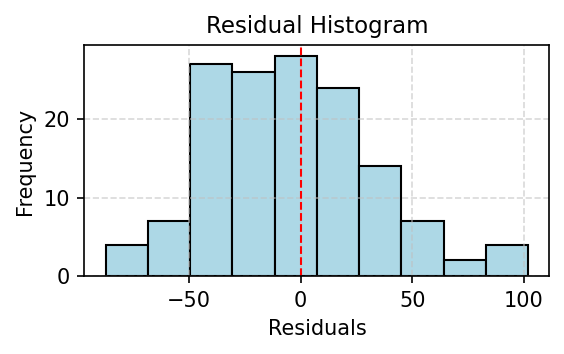

In [25]:
residuals = X_train.TEU[s+d:] - fitted[s+d:]

plt.figure(figsize=(4, 2))
plt.hist(residuals, bins=10, color= 'lightblue', edgecolor='black')
plt.axvline(x=0, color='red', linestyle='--')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residual Histogram')
plt.show()

# Export forecast

In [ ]:
forecast = pd.DataFrame(forecast)
forecast.columns = ['Arima']
forecast.index = X_test.index
forecast.to_csv('../Data/forecast_Arima.csv')

#  Check Full Data + forecast 2025

In [ ]:
Test = best_model.fittedvalues
full_model = best_model.predict(start = X_train.shape[0], end = X_train.shape[0]+X_test.shape[0]+11)

Total_2025 = sum(full_model[-12:])
total_test = sum(Test[-12:])



MAPE_train= mean_absolute_percentage_error(Month_data['TEU'][s+d:], Test[s+d:])

MAPE_test = error_test

model = pd.concat([Test, full_model])
print(MAPE_train)
print(MAPE_test)

3.651650663856808
8.40640737003326


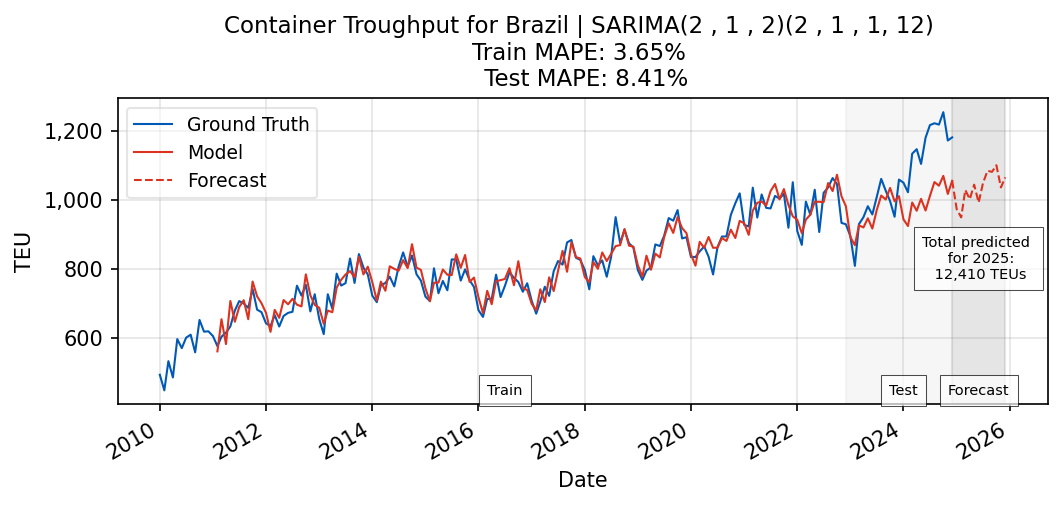

In [ ]:
plt.figure(figsize=(8, 3))

sns.lineplot(x=Month_data.index, y=Month_data['TEU'], label='Ground Truth', color= blue)
sns.lineplot(x=model.index[13:-12], y=model[13:-12], label='Model', color = red )
sns.lineplot(x=model.index[-13:], y=model[-13:], label='Forecast', color = red, linestyle='dashed')

plt.axvspan(Month_data.index[-1], full_model.index[-1], alpha=0.2, color='grey')

plt.axvspan(X_train.index[-1], X_test.index[-1], alpha=0.2, color='lightgrey')

plt.xlabel('Date')
plt.ylabel('TEU')
plt.legend(loc='best', fontsize=9, framealpha=0.5)
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
plt.grid( True, which='major', color='grey', linestyle='-', alpha=0.2)
plt.gcf().autofmt_xdate() 


plt.text(model.index[-len(model[-13:])//2],
         min(model[s+d:])+(max(model) - min(model[s+d:]))/2,
        'Total predicted \n for 2025:\n {:,.0f} TEUs'.format(Total_2025),
        fontsize=7, 
         bbox=dict(facecolor='white',
                   alpha=0.7,
                   edgecolor='black',
                   linewidth=0.5),
                   va='center',
                   ha='center'
        )

plt.text(model.index[-len(model[-13:])//2],
         min(plt.ylim())*1.1,
        'Forecast',
        fontsize=7, 
         bbox=dict(facecolor='white',
                   alpha=0.7,
                   edgecolor='black',
                   linewidth=0.5),
                   va='center',
                   ha='center'
        )

plt.text(X_test.index[-len(X_test)//2],
         min(plt.ylim())*1.1,
        'Test',
        fontsize=7, 
         bbox=dict(facecolor='white',
                   alpha=0.7,
                   edgecolor='black',
                   linewidth=0.5),
                   va='center',
                   ha='center'
        )

plt.text(X_train.index[-len(X_train)//2],
         min(plt.ylim())*1.1,
        'Train',
        fontsize=7, 
         bbox=dict(facecolor='white',
                   alpha=0.7,
                   edgecolor='black',
                   linewidth=0.5),
                   va='center',
                   ha='center'
        )

#plt.title('SARIMA ({:.2f}) - Container Troughput for Brazil \n Train MAPE: {:.2f}% \n Test MAPE: {:.2f}%'.format(MAPE_train, MAPE_test), fontsize=15)
plt.title(f'Container Troughput for Brazil | SARIMA({p} , {d} , {q})({P} , {D} , {Q}, {s}) \nTrain MAPE: {MAPE_train:.2f}% \n Test MAPE: {MAPE_test:.2f}%')


plt.show();

# Benchmark with RASHED et al (2013)

                                     SARIMAX Results                                      
Dep. Variable:                                TEU   No. Observations:                  156
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -720.510
Date:                            Sat, 03 May 2025   AIC                           1447.020
Time:                                    17:26:44   BIC                           1455.909
Sample:                                01-01-2010   HQIC                          1450.632
                                     - 12-01-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5029      0.069     -7.275      0.000      -0.638      -0.367
ma.S.L12      -0.8765      0.103   

C:\Users\rafae\AppData\Local\Temp\ipykernel_6788\1812065425.py:16: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['arima_model'][:s+d] = np.NaN
C:\Users\rafae\AppData\Local\Temp\ipykernel_6788\1812065425.py:16: FutureWarning: ChainedAssi

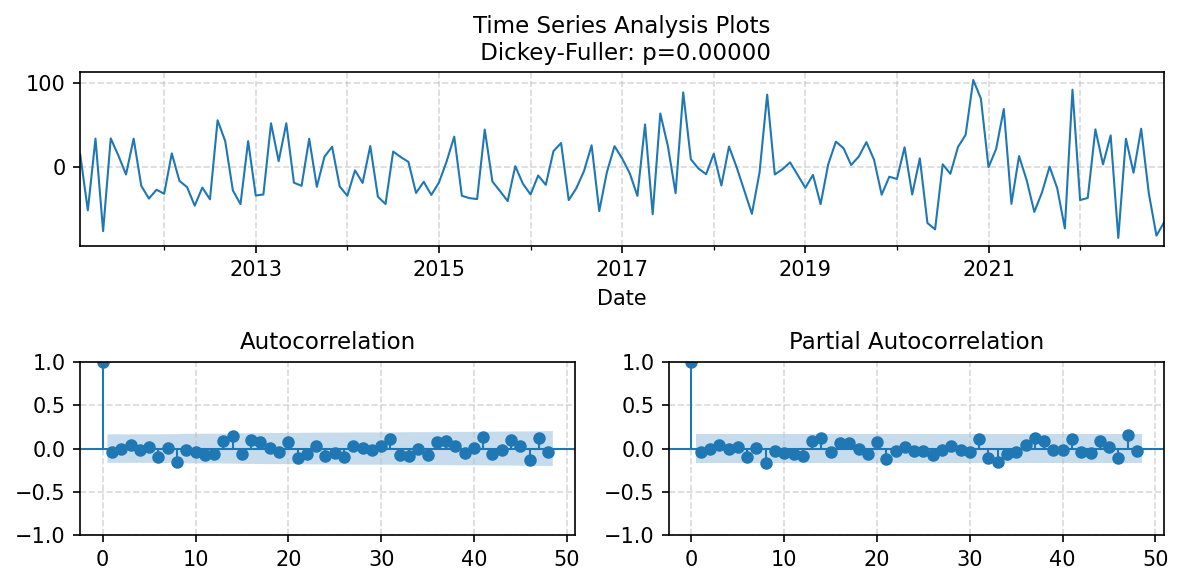

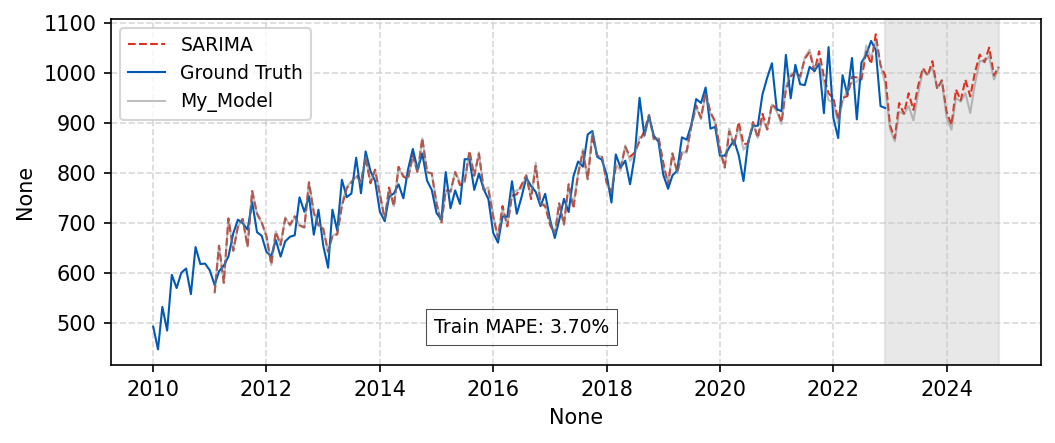

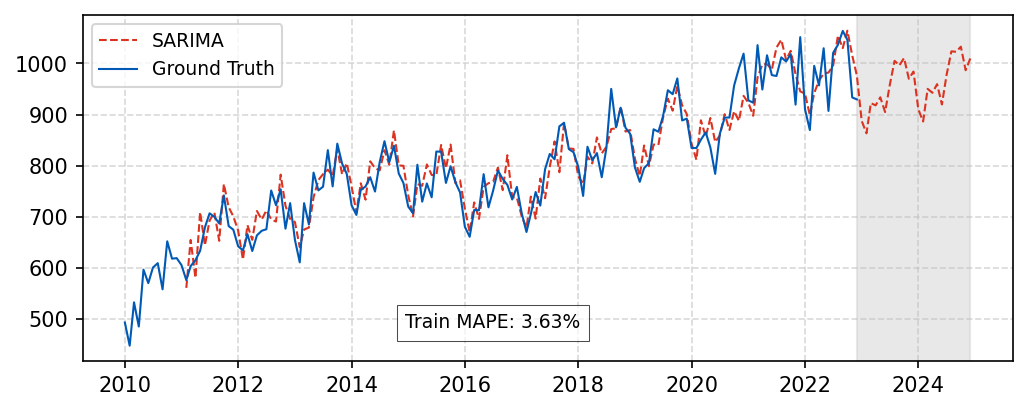

In [ ]:
rashed_model=sm.tsa.statespace.SARIMAX(X_train, order=(0, 1, 1), 
                                        seasonal_order=(0, 1, 1, s),
                                        ).fit(disp=-1)
print(rashed_model.summary())

tsplot(rashed_model.resid[12+1:], lags=48)


plotSARIMA(X_train, rashed_model, len(X_test))
sns.lineplot(x=model.index[13:-12], y=model[13:-12], label='My_Model', color ='grey', alpha = 0.5)


plotSARIMA(X_train, best_model, len(X_test))



